In [1]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [2]:
# Importing Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import chain
from collections import Counter
import operator as op
from prince import FAMD, MCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Adjustment Options
pd.set_option('display.max_columns', None) # Display All Columns given the dataset has many columns
pd.set_option('display.max_rows',75)


# Exploring .csv kaggle files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.split(".")[-1] == "csv":
            print(os.path.join(dirname, filename))


/kaggle/input/mental-health-in-tech-2016/mental-heath-in-tech-2016_20161114.csv


In [3]:
df = pd.read_csv("/kaggle/input/mental-health-in-tech-2016/mental-heath-in-tech-2016_20161114.csv")
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

In [4]:
for i, column in enumerate(df.columns):
    print(i, column)

0 Are you self-employed?
1 How many employees does your company or organization have?
2 Is your employer primarily a tech company/organization?
3 Is your primary role within your company related to tech/IT?
4 Does your employer provide mental health benefits as part of healthcare coverage?
5 Do you know the options for mental health care available under your employer-provided coverage?
6 Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
7 Does your employer offer resources to learn more about mental health concerns and options for seeking help?
8 Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
9 If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
10 Do you think that discussing a mental health disorder with your employer would have negative consequences?

# Data Cleaning
- Dealing with Nan values
- Dealing with ordinal and nominal columns
- Normalizing Data

In [5]:
# a threshold for Nan values
nan_column_threshold = df.shape[0]*.25
nan_row_threshold = df.shape[1]*.25
nan_column_threshold, nan_row_threshold

(358.25, 15.75)

In [6]:
df.isna().sum()

Are you self-employed?                                                                                                                                                                 0
How many employees does your company or organization have?                                                                                                                           287
Is your employer primarily a tech company/organization?                                                                                                                              287
Is your primary role within your company related to tech/IT?                                                                                                                        1170
Does your employer provide mental health benefits as part of healthcare coverage?                                                                                                    287
Do you know the options for mental health care available under your employe

In [7]:
df.loc[:,df.isna().sum() > nan_column_threshold]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Is your primary role within your company related to tech/IT?,Do you know the options for mental health care available under your employer-provided coverage?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,"If yes, what condition(s) have you been diagnosed with?","If maybe, what condition(s) do you believe you have?","If so, what condition(s) were you diagnosed with?",What US state or territory do you live in?,What US state or territory do you work in?
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,NaN
1,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",Illinois,Illinois
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,"Yes, I know several","Sometimes, if it comes up",I'm not sure,"Sometimes, if it comes up",I'm not sure,Yes,1-25%,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,NaN
4,1.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",Illinois,Illinois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,NaN,NaN,1.0,"Yes, I know several",Not applicable to me,NaN,Not applicable to me,Not applicable to me,Not applicable to me,NaN,NaN,NaN,NaN,NaN,New York,New York
1429,NaN,NaN,1.0,I know some,"No, because it doesn't matter",No,"No, because it doesn't matter",No,No,NaN,Maybe,NaN,NaN,"Psychotic Disorder (Schizophrenia, Schizoaffec...",California,NaN
1430,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...","Anxiety Disorder (Generalized, Social, Phobia,...",Georgia,Georgia
1431,1.0,I am not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Mood Disorder (Depression, Bipolar Disorder, etc)",Nebraska,Nebraska


In [8]:
df.loc[df.isna().sum(axis=1) > nan_row_threshold,:]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a menta

In [9]:
df.loc[df.isna().sum(axis=1) > nan_row_threshold,:].isna().sum(axis=1)

0       17
3       19
9       18
17      16
18      28
        ..
1420    21
1423    26
1428    21
1429    30
1432    26
Length: 494, dtype: int64

## Nan Values
- 16 columns have more than 25% of Nan values but this could be to no answer or inapplicable. to be reviewed.
- 494 respondents didnt answer more than 25% of the survey. Theyll be dropped and considered inaccurate responses. 

In [10]:
df_2 = df.loc[df.isna().sum(axis=1) < nan_row_threshold,:]
df_2.shape

(939, 63)

In [11]:
df_2.loc[:,df_2.isna().sum() > nan_column_threshold] # Checking again for column Nans

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Is your primary role within your company related to tech/IT?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,"If yes, what condition(s) have you been diagnosed with?","If maybe, what condition(s) do you believe you have?","If so, what condition(s) were you diagnosed with?"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mood Disorder (Depression, Bipolar Disorder, etc)",NaN
1426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,Attention Deficit Hyperactivity Disorder,NaN,Attention Deficit Hyperactivity Disorder
1427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,"Anxiety Disorder (Generalized, Social, Phobia,...",NaN,"Anxiety Disorder (Generalized, Social, Phobia,..."
1430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,"Anxiety Disorder (Generalized, Social, Phobia,...","Anxiety Disorder (Generalized, Social, Phobia,..."


In [12]:
df_2.loc[:,df_2.isna().sum() > nan_column_threshold].columns

Index(['Is your primary role within your company related to tech/IT?',
       'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?',
       'Do you know local or online resources to seek help for a mental health disorder?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
       'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
       'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
       'Do you believe your productivity is ever affected by a mental health issue?',
       'If yes, what percentage of your work time (time performing primary or secondary job func

## Fill NaN with inapplicable or no asnwer or drop

In [13]:
# No Answer Columns
# any columns with a determinate answer but with Nan will be dropped
drop_columns = ['Is your primary role within your company related to tech/IT?',
                'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?',
                'Do you know local or online resources to seek help for a mental health disorder?'
               ]

# Questions that deal with belief or witness will be filled with 'no answer'
no_asnwers_cols = ['Do you believe your productivity is ever affected by a mental health issue?',
                  'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?'
                  ]

# Any 'If questions' will be filled with inapplicable 
inapplicable_cols = ['If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
                    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
                    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
                    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
                    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
                    'If yes, what condition(s) have you been diagnosed with?',
                    'If maybe, what condition(s) do you believe you have?',
                    'If so, what condition(s) were you diagnosed with?'
                    ]

In [14]:
df_3 = df_2.drop(columns=drop_columns, axis=1)
df_3

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your obse

In [15]:
df_3.loc[:,no_asnwers_cols] = df_3.loc[:,no_asnwers_cols].fillna("No Answer")

In [16]:
df_3.loc[:,inapplicable_cols] = df_3.loc[:,inapplicable_cols].fillna("Inapplicable")

In [17]:
df_3.loc[:,df_3.isna().sum() > 0]

,Do you know the options for mental health care available under your employer-provided coverage?,Why or why not?,Why or why not?.1,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,What is your gender?,What US state or territory do you live in?,What US state or territory do you work in?
1,Yes,It would depend on the health issue. If there ...,While mental health has become a more prominen...,No,male,Illinois,Illinois
2,NaN,"They would provable need to know, to Judge if ...","Stigma, mainly.",Maybe/Not sure,Male,NaN,NaN
4,Yes,Depending on the interview stage and whether I...,I don't know,"Yes, I experienced",Female,Illinois,Illinois
5,I am not sure,If it would potentially affect my ability to d...,It would depend on the field & what I knew of ...,"Yes, I experienced",Male,NaN,NaN
6,No,I want to gauge their ability to support this ...,"I want to gauge their ability to support, unde...",No,M,Tennessee,Tennessee
...,...,...,...,...,...,...,...
1425,I am not sure,NaN,Stigma.,No,Male,NaN,NaN
1426,I am not sure,NaN,NaN,"Yes, I experienced",Female,NaN,NaN
1427,No,I would be afraid it would reflect poorly on me.,I would be certain it would reflect poorly on me.,"Yes, I experienced",female,Illinois,Illinois
1430,Yes,Fear that doing so would cause the employer to...,Fear that the employer would consider addition...,"Yes, I observed",Male,Georgia,Georgia


In [18]:
for column in df_3.loc[:,df_3.isna().sum() > 0].columns:
    print(f"{column}:\t{df_3[column].isna().sum()}")

Do you know the options for mental health care available under your employer-provided coverage?:	85
Why or why not?:	189
Why or why not?.1:	164
Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?:	28
What is your gender?:	3
What US state or territory do you live in?:	306
What US state or territory do you work in?:	302


In [19]:
df_4 = df_3.copy()

In [20]:
df_4.loc[:,df_4.isna().sum() > 0] = df_4.loc[:,df_4.isna().sum() > 0].fillna("No Answer")

In [21]:
df_4.loc[:,df_4.isna().sum() > 0]

""
1
2
4
5
6
...
1425
1426
1427
1430


All Nan Values have been adjusted

In [22]:
df_4.reset_index(drop=True,inplace=True)

## Noramlizing Answers in the Dataset

In [23]:
df_4.head()

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?.1,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your obse

In [24]:
one_unique_answer = []
for i,column in enumerate(df_4.columns):
    if len(df_4[column].unique()) > 1:
        print(f"****{i, column}****")
        print(df_4[column].unique())
        print("\n")
    else:
        one_unique_answer.append(column)
print("The following columns have one unique answer:")
print(*one_unique_answer,sep="\n")
    

****(1, 'How many employees does your company or organization have?')****
['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']


****(2, 'Is your employer primarily a tech company/organization?')****
[1. 0.]


****(3, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(4, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(5, 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?')****
['Yes' 'No' "I don't know"]


****(6, 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')****
['Yes' 'No' "I don't know"]


****(7, 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided

## First Iteration of Normalizing and Further cleaning
- Columns with one unique answers will be dropped.
- Why or Why not columns need sentiment analysis but for this exercise, will be dropped.
- US terrirotires question will be dropped.
- Genders will be condensed to Male, Female and Other
- questions 44-46 that will be dropped as 47 is representative

In [25]:
df_5 = df_4.drop(one_unique_answer,axis=1)

In [26]:
dropped_columns = ['What US state or territory do you work in?',
                  'What US state or territory do you live in?',
                  'Why or why not?.1',
                  'Why or why not?',
                  'Do you currently have a mental health disorder?',
                  'If yes, what condition(s) have you been diagnosed with?',
                  'If maybe, what condition(s) do you believe you have?']

df_5 = df_5.drop(dropped_columns, axis=1)

In [27]:
def normalize_gender(gender):
    if type(gender) != str:
        raise ValueError("Gender must be a string")
    gender = gender.strip().lower()
    for female in ['female', 'woman','f']:   
        if op.contains(gender,female):
            return 'Female'
    for male in ['male','man','m']:
        if op.contains(gender,male):
            return 'Male'
    return "Other"

In [28]:
df_5.loc[:,"What is your gender?"] = df_5.loc[:,"What is your gender?"].map(normalize_gender)

In [29]:
# doubel checking result
one_unique_answer = []
for i,column in enumerate(df_5.columns):
    if len(df_5[column].unique()) > 1:
        print(f"****{i, column}****")
        print(df_5[column].unique())
        print("\n")
    else:
        one_unique_answer.append(column)
print("The following columns have one unique answer:")
print(*one_unique_answer,sep="\n")

****(0, 'How many employees does your company or organization have?')****
['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']


****(1, 'Is your employer primarily a tech company/organization?')****
[1. 0.]


****(2, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(3, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(4, 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?')****
['Yes' 'No' "I don't know"]


****(5, 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')****
['Yes' 'No' "I don't know"]


****(6, 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided

In [30]:
df_5["What country do you live in?"].value_counts()/df_5.shape[0]

What country do you live in?
United States of America    0.674121
United Kingdom              0.104366
Canada                      0.053248
Netherlands                 0.022364
Germany                     0.022364
Australia                   0.021299
Brazil                      0.009585
France                      0.008520
Ireland                     0.008520
Sweden                      0.008520
Switzerland                 0.005325
New Zealand                 0.005325
Finland                     0.004260
Bulgaria                    0.004260
Denmark                     0.004260
India                       0.003195
Spain                       0.003195
South Africa                0.003195
Chile                       0.003195
Russia                      0.003195
Pakistan                    0.003195
Norway                      0.002130
Afghanistan                 0.002130
Italy                       0.002130
Israel                      0.002130
Estonia                     0.002130
Colombia 

In [31]:
df_5['What country do you work in?'].value_counts()/df_5.shape[0]

What country do you work in?
United States of America    0.678381
United Kingdom              0.103301
Canada                      0.052183
Netherlands                 0.022364
Germany                     0.022364
Australia                   0.021299
Brazil                      0.009585
Sweden                      0.009585
France                      0.008520
Ireland                     0.008520
Switzerland                 0.005325
New Zealand                 0.005325
Bulgaria                    0.004260
Finland                     0.004260
Denmark                     0.004260
Russia                      0.003195
Chile                       0.003195
India                       0.003195
South Africa                0.003195
Estonia                     0.002130
Colombia                    0.002130
Spain                       0.002130
Norway                      0.002130
Pakistan                    0.002130
Israel                      0.002130
Austria                     0.001065
Bosnia an

In [32]:
df_5[df_5["What country do you work in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"])].shape

(845, 45)

In [33]:
df_5[df_5["What country do you live in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"])].shape

(843, 45)

In [34]:
remaining_obs = df_5[(df_5["What country do you live in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"]))&
(df_5["What country do you work in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"]))].shape[0]

total_obs = df_5.shape[0]

print(f"Drop percentage {1 - (remaining_obs/total_obs):.2f}")

Drop percentage 0.10


## Second Iteration of Normalizing and Further cleaning
- Create Dummy variables for questions 43 and 35
- Will only include United States of America, United Kingdom, Canada, Netherlands, Germany, Australia 

In [35]:
df_6 = df_5[(df_5["What country do you live in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"]))&
            (df_5["What country do you work in?"].isin(["United States of America", "United Kingdom", "Canada", "Netherlands", "Germany", "Australia"]))]
df_6.shape

(842, 45)

In [36]:
work_positions_df = df_6.iloc[:,43].str.get_dummies(sep="|")
work_positions_df.columns = [f"Work_Position_{x}" for x in work_positions_df.columns]
work_positions_df.head()

,Work_Position_Back-end Developer,Work_Position_Designer,Work_Position_Dev Evangelist/Advocate,Work_Position_DevOps/SysAdmin,Work_Position_Executive Leadership,Work_Position_Front-end Developer,Work_Position_HR,Work_Position_One-person shop,Work_Position_Other,Work_Position_Sales,Work_Position_Supervisor/Team Lead,Work_Position_Support
0,1,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,1,1,0,0,0,0,1,1
3,1,1,0,1,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df_7 = pd.concat([df_6,work_positions_df],axis=1).drop("Which of the following best describes your work position?",axis=1)

In [38]:
df_7.head()

,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Have you been diagnosed with a mental health condition by a medical professional?,"If so, what condition(s) were you diagnosed with?",Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What c

In [39]:
mental_health_df = df_7.iloc[:,35].str.get_dummies(sep="|")
mental_health_df.columns = [f"{x}_Diagnosed_Mental_Health" for x in mental_health_df.columns]
mental_health_df.head()

,ADD (w/o Hyperactivity)_Diagnosed_Mental_Health,Addictive Disorder_Diagnosed_Mental_Health,"Anxiety Disorder (Generalized, Social, Phobia, etc)_Diagnosed_Mental_Health",Asperger Syndrome_Diagnosed_Mental_Health,Attention Deficit Disorder_Diagnosed_Mental_Health,Attention Deficit Hyperactivity Disorder_Diagnosed_Mental_Health,Autism_Diagnosed_Mental_Health,Autism (Asperger's)_Diagnosed_Mental_Health,"Autism - while not a ""mental illness"", still greatly affects how I handle anxiety_Diagnosed_Mental_Health",Autism Spectrum Disorder_Diagnosed_Mental_Health,Dissociative Disorder_Diagnosed_Mental_Health,"Eating Disorder (Anorexia, Bulimia, etc)_Diagnosed_Mental_Health",Gender Identity Disorder_Diagnosed_Mental_Health,Inapplicable_Diagnosed_Mental_Health,"Mood Disorder (Depression, Bipolar Disorder, etc)_Diagnosed_Mental_Health",Obsessive-Compulsive Disorder_Diagnosed_Mental_Health,"Personality Disorder (Borderline, Antisocial, Paranoid, etc)_Diagnosed_Mental_Health",Post-traumatic Stress Disorder_Diagnosed_Mental_Health,"Psychotic Disorder (Schizophrenia, Schizoaffective, etc)_Diagnosed_Mental_Health",Seasonal Affective Disorder_Diagnosed_Mental_Health,Stress Response Syndromes_Diagnosed_Mental_Health,Substance Use Disorder_Diagnosed_Mental_Health,Suicidal Ideation_Diagnosed_Mental_Health,attention deficit disorder (but not the hyperactive version)_Diagnosed_Mental_Health,posttraumatic stress disourder_Diagnosed_Mental_Health
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [40]:
df_8 = pd.concat([df_7,mental_health_df],axis=1).drop(['Have you been diagnosed with a mental health condition by a medical professional?',
                                                       'If so, what condition(s) were you diagnosed with?'],axis=1)

In [41]:
# doubel checking result
for i,column in enumerate(df_8.columns):
    print(f"****{i, column}****")
    print(df_8[column].unique())
    print("\n")


****(0, 'How many employees does your company or organization have?')****
['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']


****(1, 'Is your employer primarily a tech company/organization?')****
[1. 0.]


****(2, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(3, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(4, 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?')****
['Yes' 'No' "I don't know"]


****(5, 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')****
['Yes' 'No' "I don't know"]


****(6, 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided

In [42]:
df_8.shape

(842, 79)

In [43]:
df_8.loc[:,df_8.isna().sum() > 0]

""
0
1
2
3
4
...
934
935
936
937


## Third Iteration of Normalizing and Further cleaning
- Combine Autism Columns 60:63
- handle age outliers
- Encode ordinal scales
- ensure all nominal columns are dummies

In [44]:
df_8[(df_8["What is your age?"] >= 18) & (df_8["What is your age?"] <= 75)].shape

(839, 79)

In [45]:
df_9 = df_8[(df_8["What is your age?"] >= 18) & (df_8["What is your age?"] <= 75)]

In [46]:
autism_cols = df_9.columns[60:64]
df_9["Autism_any_Diagnosed_Mental_Health"] = df_9[autism_cols].max(axis=1)
df_10 = df_9.drop(columns=autism_cols)
df_10.head()

/tmp/ipykernel_13/1385587379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9["Autism_any_Diagnosed_Mental_Health"] = df_9[autism_cols].max(axis=1)


,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What country do you work in?,Do you work remotely?,Work_Position_Back-end Developer,Work_Position_Designer,Work_Position_Dev Evangelist/Advo

In [47]:
# Company size mapping (ordered) Question 7
size_map = {
    "1-5": 1, 
    "6-25": 2, 
    "26-100": 3,
    "100-500": 4, 
    "500-1000": 5, 
    "More than 1000": 6
}
df_10["How many employees does your company or organization have?"] = df_10["How many employees does your company or organization have?"].map(size_map)

In [48]:
# Example for Likert scale question
work_leave_map = {
    "Very difficult": 1, 
    "Somewhat difficult": 2,
    "Neither easy nor difficult": 3,
    "Somewhat easy": 4, 
    "Very easy": 5,
    "I don't know": 3  # treating it as a neutral response
}
df_10["If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:"] = df_10["If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:"].map(work_leave_map)


In [49]:
for i,column in enumerate(df_10.select_dtypes(include=['object']).columns):
    print(f"****{i, column}****")
    print(df_10[column].unique())
    print("\n")

****(0, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(1, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(2, 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?')****
['Yes' 'No' "I don't know"]


****(3, 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')****
['Yes' 'No' "I don't know"]


****(4, 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?')****
['Yes' "I don't know" 'No']


****(5, 'Do you think that discussing a mental health disorder with your employer would have negative consequences?')****
['No' 'Maybe' 'Yes']


****(6, 'Do you thi

In [50]:
ordinal_map = {
    "No": 0,
    "Maybe": 1,
    "Yes": 2
}

for i,column in enumerate(df_10.select_dtypes(include=['object']).columns):
    if set(df_10[column].unique()) == {"Yes", "No", "Maybe"}:
        df_10[f"ord_{column}"] = df[column].map(ordinal_map)
        df_10.drop(column,axis=1,inplace=True)

In [51]:
for i,column in enumerate(df_10.select_dtypes(include=['object']).columns):
    print(f"****{i, column}****")
    print(df_10[column].unique())
    print("\n")

****(0, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(1, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(2, 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?')****
['Yes' 'No' "I don't know"]


****(3, 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?')****
['Yes' 'No' "I don't know"]


****(4, 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?')****
['Yes' "I don't know" 'No']


****(5, 'Do you feel that your employer takes mental health as seriously as physical health?')****
['Yes' "I don't know" 'No']


****(6, 'Have you heard of or obser

In [52]:
dummy_cols = []

for i,column in enumerate(df_10.select_dtypes(include=['object']).columns):
    if set(df_10[column].unique()) == {"Yes", "No", "I don't know"}:
        dummy_cols.append(column)
dummy_cols

['Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'Do you feel that your employer takes mental health as seriously as physical health?',
 'Do you have a family history of mental illness?']

In [53]:
  other_dummy_cols = ["What country do you live in?",
                     "What country do you work in?",
                     "What is your gender?"]
dummy_cols = list(chain(dummy_cols,other_dummy_cols))
dummy_cols

['Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'Do you feel that your employer takes mental health as seriously as physical health?',
 'Do you have a family history of mental illness?',
 'What country do you live in?',
 'What country do you work in?',
 'What is your gender?']

In [54]:
df_11 = pd.get_dummies(df_10, 
                    columns=dummy_cols, 
                    drop_first=False)

In [55]:
for i,column in enumerate(df_11.select_dtypes(include=['object']).columns):
    print(f"****{i, column}****")
    print(df_10[column].unique())
    print("\n")

****(0, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
['No' 'Yes' "I don't know" 'Not eligible for coverage / N/A']


****(1, 'Do you know the options for mental health care available under your employer-provided coverage?')****
['Yes' 'No Answer' 'I am not sure' 'No']


****(2, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?')****
['No' 'Yes']


****(3, 'Have your previous employers provided mental health benefits?')****
['Yes, they all did' 'No, none did' "I don't know" 'Some did']


****(4, 'Were you aware of the options for mental health care provided by your previous employers?')****
['I was aware of some' 'N/A (not currently aware)'
 'Yes, I was aware of all of them' 'No, I only became aware later']


****(5, 'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?')****
['None did

In [56]:
def encode_columns(df, column, mapper):
    df[column] = df[column].map(mapper)

In [57]:
ordinal_maps = {

    # Employer support / awareness
    'Does your employer provide mental health benefits as part of healthcare coverage?': {
        'Yes': 0,
        'No': 2,
        "I don't know": 1,
        'Not eligible for coverage / N/A': np.nan
    },
    'Do you know the options for mental health care available under your employer-provided coverage?': {
        'Yes': 0,
        'No': 2,
        'I am not sure': 1,
        'No Answer': np.nan
    },
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': {
        'No': 0,
        'Yes': 1
    },

    # Previous employer support
    'Have your previous employers provided mental health benefits?': {
        'Yes, they all did': 0,
        'Some did': 1,
        "I don't know": 2,
        'No, none did': 3
    },
    'Were you aware of the options for mental health care provided by your previous employers?': {
        'Yes, I was aware of all of them': 0,
        'I was aware of some': 1,
        'No, I only became aware later': 2,
        'N/A (not currently aware)': np.nan
    },
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': {
        'Yes, they all did': 0,
        'Some did': 1,
        "I don't know": 2,
        'None did': 3
    },
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': {
        'Yes, they all did': 0,
        'Some did': 1,
        'None did': 2
    },
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': {
        'Yes, always': 0,
        'Sometimes': 1,
        "I don't know": 2,
        'No': 3
    },

    # Stigma in previous workplaces
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': {
        'None of them': 0,
        'Some of them': 1,
        'Yes, all of them': 2,
        "I don't know": np.nan
    },
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': {
        'None of them': 0,
        'Some of them': 1,
        'Yes, all of them': 2
    },
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': {
        'Yes, at all of my previous employers': 0,
        'Some of my previous employers': 1,
        'No, at none of my previous employers': 2
    },
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': {
        'Yes, at all of my previous employers': 0,
        'Some of my previous employers': 1,
        "I don't know": 2,
        'No, at none of my previous employers': 3
    },
    'Did you feel that your previous employers took mental health as seriously as physical health?': {
        'Yes, they all did': 0,
        'Some did': 1,
        'None did': 2,
        "I don't know": np.nan
    },
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': {
        'None of them': 0,
        'Some of them': 1,
        'Yes, all of them': 2
    },

    # Current stigma perception
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': {
        "No, I don't think it would": 0,
        'Maybe': 1,
        'Yes, I think it would': 2,
        'No, it has not': 0, # treating the respondent's perception as constant regardless of team members actions
        'Yes, it has': 2
    },
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': {
        "No, I don't think they would": 0,
        'Maybe': 1,
        'Yes, I think they would': 2,
        'Yes, they do': 2,  # treating the respondent's perception as constant regardless of team members actions
        'No, they do not': 0
    },

    # Disclosure to friends/family
    'How willing would you be to share with friends and family that you have a mental illness?': {
        'Very open': 0,
        'Somewhat open': 1,
        'Neutral': 2,
        'Somewhat not open': 3,
        'Not open at all': 4,
        'Not applicable to me (I do not have a mental illness)': np.nan
    },

    # Observational reactions
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': {
        'No': 0,
        'Maybe/Not sure': 1,
        'Yes, I observed': 2,
        'Yes, I experienced': 3,
        'No Answer': np.nan
    },
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': {
        'No': 0,
        'Maybe': 1,
        'Yes': 2,
        'No Answer': np.nan
    },

    # Work interference (treated vs untreated)
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': {
        'Never': 0,
        'Rarely': 1,
        'Sometimes': 2,
        'Often': 3,
        'Not applicable to me': np.nan
    },
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': {
        'Never': 0,
        'Rarely': 1,
        'Sometimes': 2,
        'Often': 3,
        'Not applicable to me': np.nan
    },

    # Remote work
    'Do you work remotely?': {
        'Always': 2,
        'Sometimes': 1,
        'Never': 0
    }
}


In [58]:
for col, mapping in ordinal_maps.items():
    encode_columns(df_11, col, mapping)

In [59]:
columns_with_na = ['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?',
                  'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
                  'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',
                  'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?',
                  'How willing would you be to share with friends and family that you have a mental illness?',
                  'Did you feel that your previous employers took mental health as seriously as physical health?',
                  'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',
                  'Were you aware of the options for mental health care provided by your previous employers?',
                  'Do you know the options for mental health care available under your employer-provided coverage?',
                  'Does your employer provide mental health benefits as part of healthcare coverage?']
for col in columns_with_na:
    new_name = col + "_NA"
    df_11[new_name] = df_11[col].isna().astype(int)

In [60]:
for i,column in enumerate(df_11.columns):
    print(f"****{i, column}****")
    print(f"Column data_type: {df_11[column].dtype}")
    print(f"Nan Values: {df_11[column].isna().sum()}")
    print(f"Unique Values: {df_11[column].unique()}")
    print("\n")

****(0, 'How many employees does your company or organization have?')****
Column data_type: int64
Nan Values: 0
Unique Values: [2 6 3 4 1 5]


****(1, 'Is your employer primarily a tech company/organization?')****
Column data_type: float64
Nan Values: 0
Unique Values: [1. 0.]


****(2, 'Does your employer provide mental health benefits as part of healthcare coverage?')****
Column data_type: float64
Nan Values: 39
Unique Values: [ 2.  0.  1. nan]


****(3, 'Do you know the options for mental health care available under your employer-provided coverage?')****
Column data_type: float64
Nan Values: 64
Unique Values: [ 0. nan  1.  2.]


****(4, 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:')****
Column data_type: int64
Nan Values: 0
Unique Values: [4 3 5 1 2]


****(5, 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?')****
Column data_type: int64


# Feature Selection & Clustering
- Focus Survey on a group of questions
- use FAMD to do feature selection

In [61]:
# Employee perception of employer/coworker support in mental health
survey_questions = [
    'Is your employer primarily a tech company/organization?',
    'Does your employer provide mental health benefits as part of healthcare coverage?',
    'Do you know the options for mental health care available under your employer-provided coverage?',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
    'Have your previous employers provided mental health benefits?',
    'Were you aware of the options for mental health care provided by your previous employers?',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?',
    'Did you feel that your previous employers took mental health as seriously as physical health?',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?',
    'How willing would you be to share with friends and family that you have a mental illness?',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',
    'Have you ever sought treatment for a mental health issue from a mental health professional?',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?',
    'ord_Do you think that discussing a mental health disorder with your employer would have negative consequences?',
    'ord_Do you think that discussing a physical health issue with your employer would have negative consequences?',
    'ord_Would you feel comfortable discussing a mental health disorder with your coworkers?',
    'ord_Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
    'ord_Would you be willing to bring up a physical health issue with a potential employer in an interview?',
    'ord_Would you bring up a mental health issue with a potential employer in an interview?',
    'ord_Have you had a mental health disorder in the past?',
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_I don't know",
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_No',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_Yes',
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?_I don't know",
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?_No',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?_Yes',
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_I don't know",
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_No',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_Yes',
    "Do you feel that your employer takes mental health as seriously as physical health?_I don't know",
    'Do you feel that your employer takes mental health as seriously as physical health?_No',
    'Do you feel that your employer takes mental health as seriously as physical health?_Yes',
    "Do you have a family history of mental illness?_I don't know",
    'Do you have a family history of mental illness?_No',
    'Do you have a family history of mental illness?_Yes',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?_NA',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?_NA',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?_NA',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_NA',
    'How willing would you be to share with friends and family that you have a mental illness?_NA',
    'Did you feel that your previous employers took mental health as seriously as physical health?_NA',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?_NA',
    'Were you aware of the options for mental health care provided by your previous employers?_NA',
    'Do you know the options for mental health care available under your employer-provided coverage?_NA',
    'Does your employer provide mental health benefits as part of healthcare coverage?_NA'
]

# Demographics (used after clustering)
demography_questions = [
    'How many employees does your company or organization have?',
    'What is your age?',
    'Do you work remotely?',
    'Work_Position_Back-end Developer',
    'Work_Position_Designer',
    'Work_Position_Dev Evangelist/Advocate',
    'Work_Position_DevOps/SysAdmin',
    'Work_Position_Executive Leadership',
    'Work_Position_Front-end Developer',
    'Work_Position_HR',
    'Work_Position_One-person shop',
    'Work_Position_Other',
    'Work_Position_Sales',
    'Work_Position_Supervisor/Team Lead',
    'Work_Position_Support',
    'What country do you live in?_Australia',
    'What country do you live in?_Canada',
    'What country do you live in?_Germany',
    'What country do you live in?_Netherlands',
    'What country do you live in?_United Kingdom',
    'What country do you live in?_United States of America',
    'What country do you work in?_Australia',
    'What country do you work in?_Canada',
    'What country do you work in?_Germany',
    'What country do you work in?_Netherlands',
    'What country do you work in?_United Kingdom',
    'What country do you work in?_United States of America',
    'What is your gender?_Female',
    'What is your gender?_Male',
    'What is your gender?_Other',
    'ADD (w/o Hyperactivity)_Diagnosed_Mental_Health',
    'Addictive Disorder_Diagnosed_Mental_Health',
    'Anxiety Disorder (Generalized, Social, Phobia, etc)_Diagnosed_Mental_Health',
    'Asperger Syndrome_Diagnosed_Mental_Health',
    'Attention Deficit Disorder_Diagnosed_Mental_Health',
    'Attention Deficit Hyperactivity Disorder_Diagnosed_Mental_Health',
    'Dissociative Disorder_Diagnosed_Mental_Health',
    'Eating Disorder (Anorexia, Bulimia, etc)_Diagnosed_Mental_Health',
    'Gender Identity Disorder_Diagnosed_Mental_Health',
    'Inapplicable_Diagnosed_Mental_Health',
    'Mood Disorder (Depression, Bipolar Disorder, etc)_Diagnosed_Mental_Health',
    'Obsessive-Compulsive Disorder_Diagnosed_Mental_Health',
    'Personality Disorder (Borderline, Antisocial, Paranoid, etc)_Diagnosed_Mental_Health',
    'Post-traumatic Stress Disorder_Diagnosed_Mental_Health',
    'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)_Diagnosed_Mental_Health',
    'Seasonal Affective Disorder_Diagnosed_Mental_Health',
    'Stress Response Syndromes_Diagnosed_Mental_Health',
    'Substance Use Disorder_Diagnosed_Mental_Health',
    'Suicidal Ideation_Diagnosed_Mental_Health',
    'attention deficit disorder (but not the hyperactive version)_Diagnosed_Mental_Health',
    'posttraumatic stress disourder_Diagnosed_Mental_Health',
    'Autism_any_Diagnosed_Mental_Health'
]


In [62]:
df_cleaned = df_11.reset_index(drop=True)

In [63]:
survey_questions_cleaned = [col for col in survey_questions if '_NA' not in col and not any(suffix in col for suffix in ['_Yes','_No',"I don't know"])]
survey_questions_cleaned

['Is your employer primarily a tech company/organization?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'Do you know the options for mental health care available under your employer-provided coverage?',
 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
 'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?',
 'Have your previous employers provided mental health benefits?',
 'Were you aware of the options for mental health care provided by your previous employers?',
 'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
 'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
 'Was your anonymity protected if you chose to take advantage of mental health or substance abuse t

In [64]:
# Subset your DataFrame
df_cleaned_survey = df_cleaned[survey_questions_cleaned].copy()

# Fill missing values for FAMD (categorical/ordinal) - using -1 as placeholder
df_cleaned_survey = df_cleaned_survey.fillna(-1)

In [65]:
df_cleaned_survey.head()

,Is your employer primarily a tech company/organization?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,Have you ever sought treatment for a mental health issue from a mental health professional?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",ord_Do you think that discussing a mental health disorder with your employer would have negative consequences?,ord_Do you think that discussing a physical health issue with your employer would have negative consequences?,ord_Would you feel comfortable discussing a mental health disorder with your coworkers?,ord_Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,ord_Would you be willing to bring up a physical health issue with a potential employer in an interview?,ord_Would you bring up a mental health issue with a potential employer in an interview?,ord_Have you had a mental health disorder in the past?
0,1.0,2.0,0.0,4,0,0,1.0,3,1,0,0.0,0,2,1,1.0,0,0,0,1.0,0.0,-1.0,1,1.0,2.0,0.0,0.0,1.0,2.0,1,1,2
1,1.0,2.0,-1.0,3,0,3,-1.0,3,1,2,-1.0,1,1,2,-1.0,1,1,1,1.0,1.0,2.0,1,-1.0,-1.0,0.0,0.0,1.0,2.0,1,0,2
2,0.0,0.0,0.0,3,0,2,-1.0,1,2,2,1.0,1,2,1,1.0,1,2,1,1.0,3.0,2.0,1,2.0,2.0,1.0,0.0,1.0,1.0,2,2,1
3,1.0,0.0,1.0,4,1,3,0.0,3,2,2,2.0,1,2,3,2.0,1,2,1,1.0,3.0,0.0,1,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,2,1,2
4,1.0,1.0,2.0,4,0,1,1.0,3,1,2,0.0,0,1,0,1.0,0,2,0,-1.0,0.0,-1.0,0,-1.0,-1.0,2.0,1.0,1.0,0.0,1,0,2


In [66]:
famd = FAMD(
    n_components=5,       # How many dimensions (principal components) we want to keep.
                          # Think of it as "compressing" your data to 5 new variables that capture the most variance.

    n_iter=3,             # Number of iterations for the SVD (Singular Value Decomposition) solver.
                          # More iterations can improve convergence for large or noisy datasets.
                          # Usually small values (3-5) are sufficient.

    copy=True,            # Whether to create a copy of the data internally.
                          # True = original DataFrame remains unchanged.
                          # False = FAMD may overwrite your original data during computation (saves memory).

    check_input=True,     # Checks if the input data is valid (e.g., correct types, no corrupted values).
                          # If False, it skips checks (faster) but errors may be harder to debug.

    engine='sklearn',     # Backend engine for computation. Options: 'auto', 'sklearn', or 'famd'.
                          # 'sklearn' uses scikit-learn’s SVD implementation.
                          # 'famd' uses Prince’s internal method.
                          # 'auto' lets Prince choose the best engine for your data.

    random_state=42       # Ensures reproducibility of results by fixing the random seed.
                          # Any integer will do; same seed = same output each time.
)
famd = famd.fit(df_cleaned_survey)

In [67]:
df_famd = famd.transform(df_cleaned_survey)
print(df_famd.head())

component         0         1         2         3         4
0          5.222322  2.140474  1.841105  3.068196 -6.961352
1         -0.754258 -1.496092 -3.041748 -2.759540  2.690594
2         -1.984476  0.186375 -2.620985  2.825253  8.985232
3         -7.907870 -0.860874  0.464638  5.928029  1.174049
4          5.635044 -0.643525  1.853071 -1.209758 -5.056768


In [68]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,23.086,7.62%,7.62%
1,21.757,7.18%,14.80%
2,17.461,5.76%,20.56%
3,13.409,4.43%,24.99%
4,12.273,4.05%,29.04%


In [69]:
famd.column_coordinates_

component,0,1,2,3,4
variable,,,,,
Is your employer primarily a tech company/organization?,0.009179,0.004163,0.001704,0.000083,0.002860
Does your employer provide mental health benefits as part of healthcare coverage?,0.010079,0.024120,0.000699,0.003312,0.000215
Do you know the options for mental health care available under your employer-provided coverage?,0.000025,0.012423,0.000009,0.013388,0.004529
Were you aware of the options for mental health care provided by your previous employers?,0.000111,0.272463,0.000688,0.001985,0.004197
Do you think that discussing a mental health disorder with previous employers would have negative consequences?,0.190927,0.051999,0.000009,0.025013,0.008732
Did you feel that your previous employers took mental health as seriously as physical health?,0.092128,0.047211,0.003409,0.016483,0.015909
How willing would you be to share with friends and family that you have a mental illness?,0.066182,0.000947,0.000222,0.005239,0.004510
Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,0.143122,0.080520,0.001018,0.008211,0.000101
Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?,0.202145,0.060549,0.004965,0.000114,0.000255


In [70]:
col_coords = famd.column_coordinates_
col_abs = col_coords.abs()
feature_strength = col_abs.max(axis=1)
feature_strength

variable
Is your employer primarily a tech company/organization?                                                                                                                             0.009179
Does your employer provide mental health benefits as part of healthcare coverage?                                                                                                   0.024120
Do you know the options for mental health care available under your employer-provided coverage?                                                                                     0.013388
Were you aware of the options for mental health care provided by your previous employers?                                                                                           0.272463
Do you think that discussing a mental health disorder with previous employers would have negative consequences?                                                                     0.190927
Did you feel that your previous employers took

In [71]:
threshold = 0.4
selected_features = feature_strength[feature_strength > threshold].index.tolist()
print(*selected_features,sep="\n")

Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
Did your previous employers provide resources to learn more about mental health issues and how to seek help?
Have your previous employers provided mental health benefits?
Would you have been willing to discuss a mental health issue with your direct supervisor(s)?
ord_Would you be willing to bring up a physical health issue with a potential employer in an interview?
ord_Would you bring up a mental health issue with a potential employer in an interview?


/tmp/ipykernel_13/1004381062.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


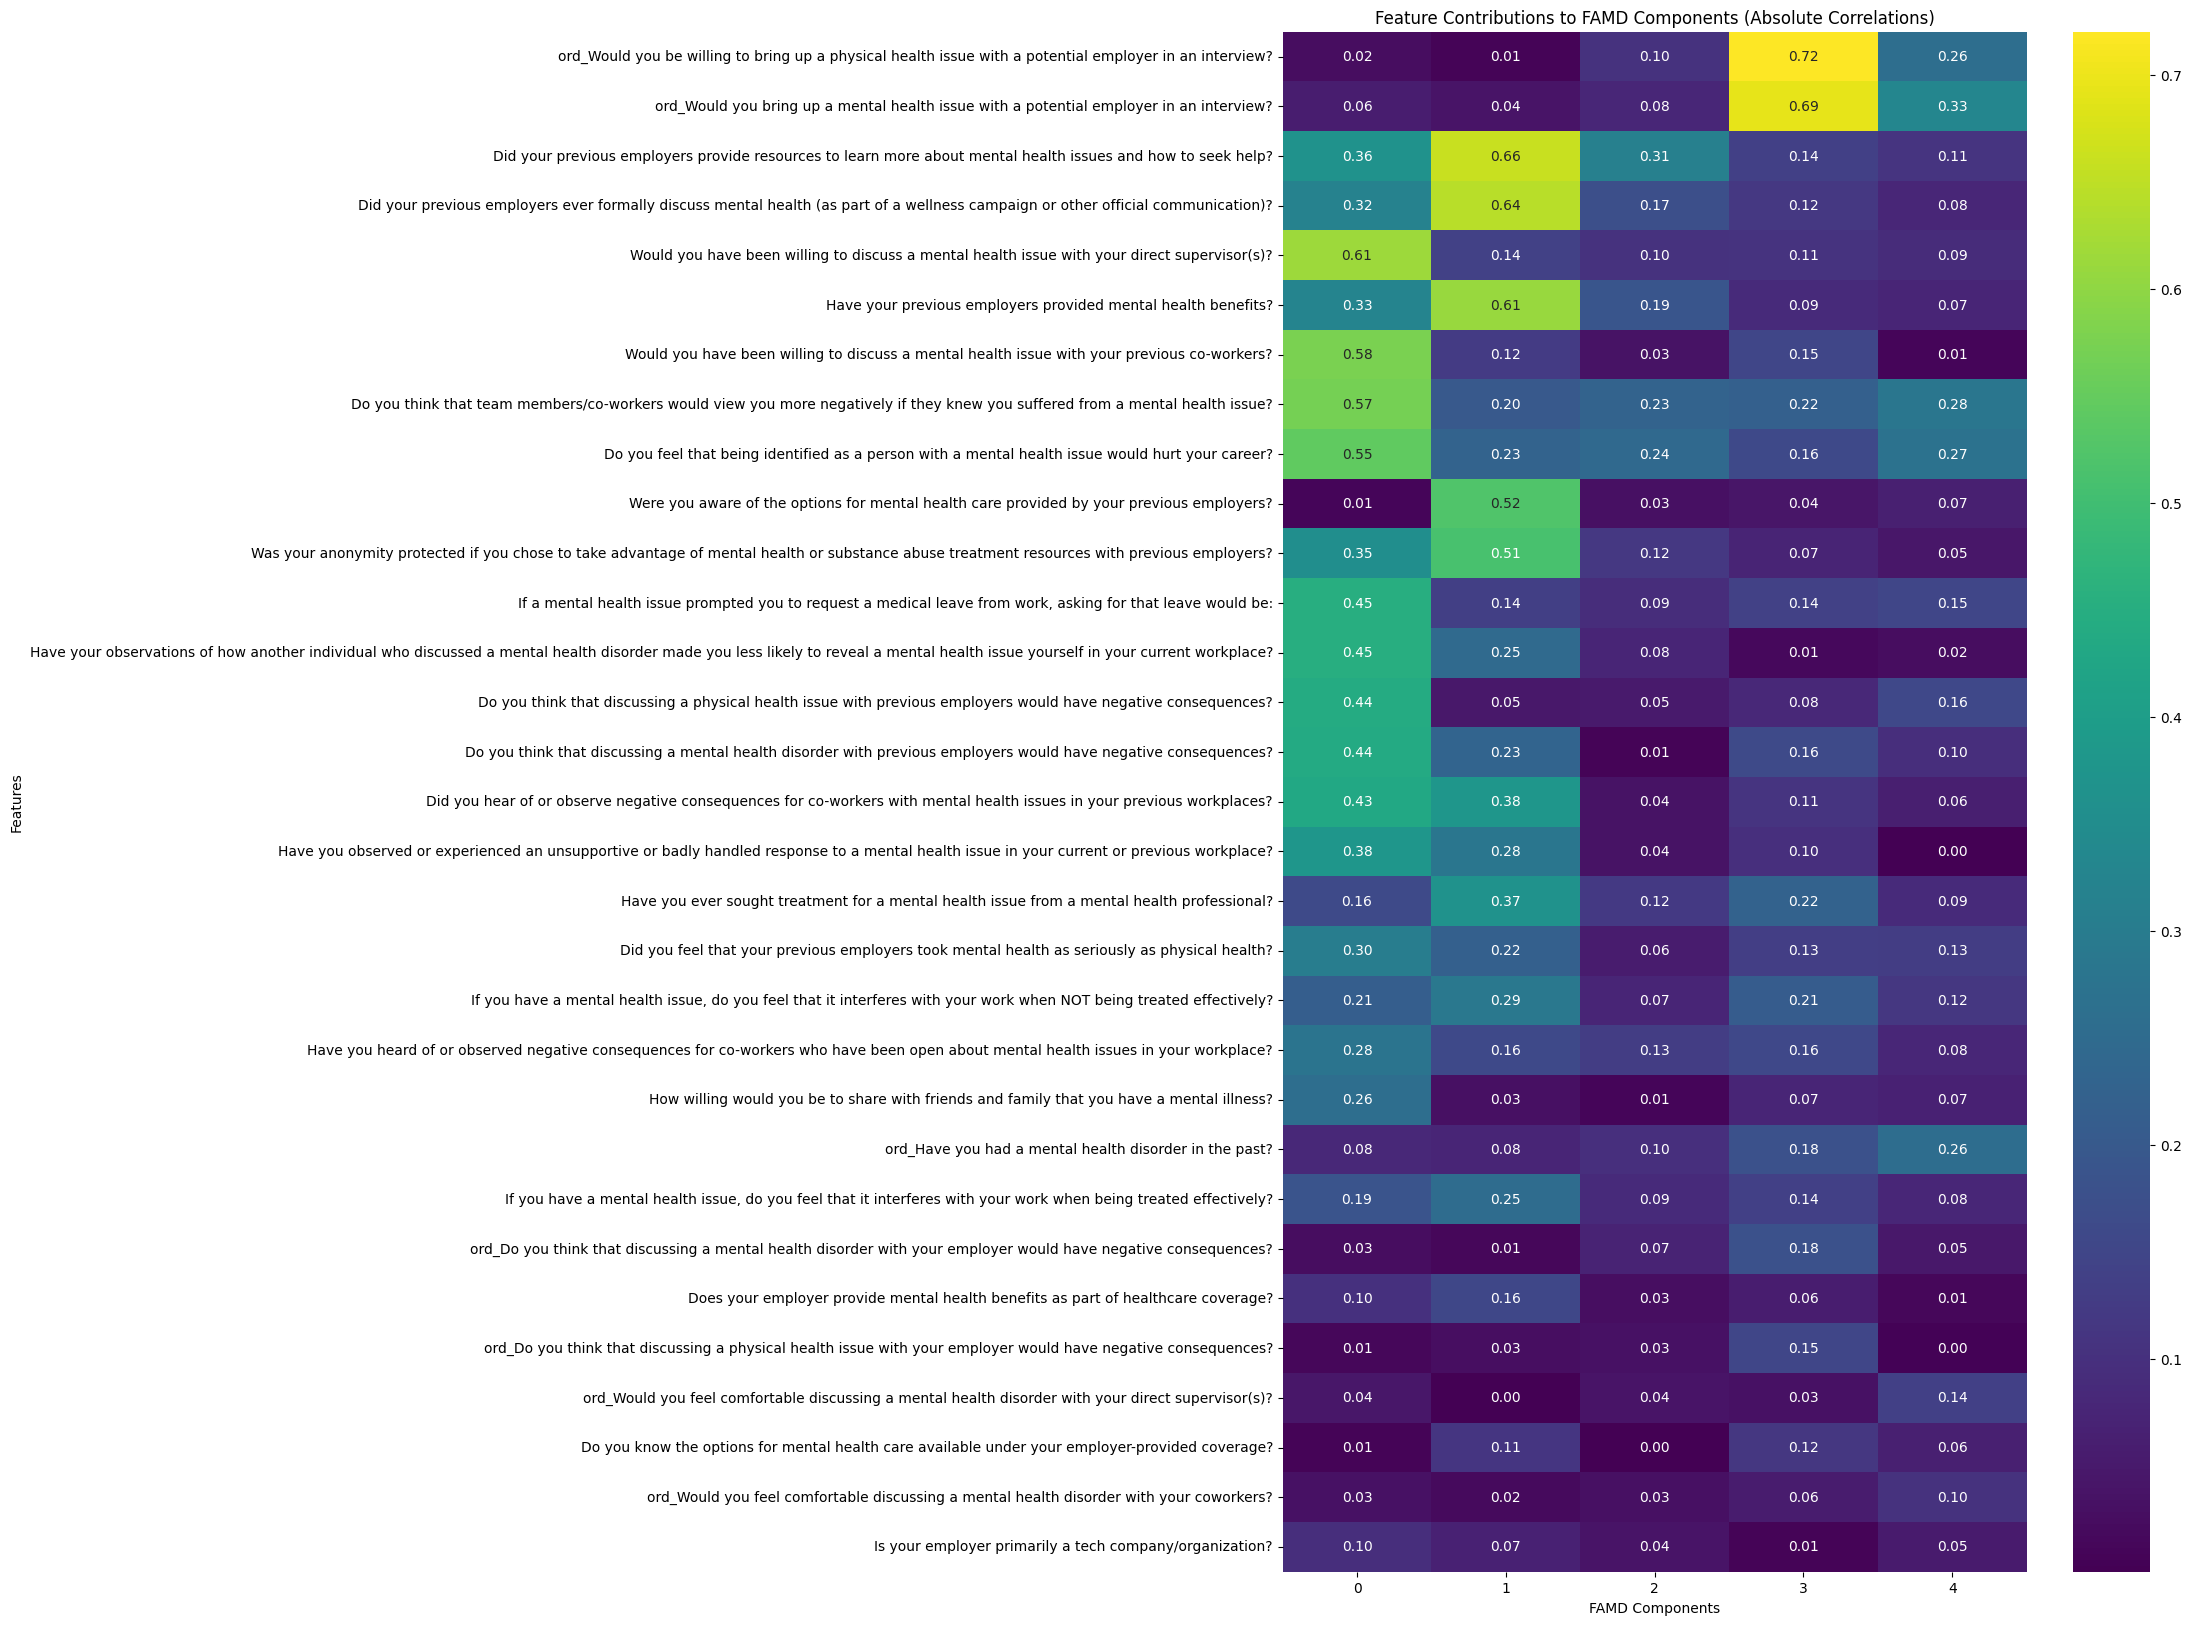

In [72]:
# Quick Standarization
df_standardized = (df_cleaned_survey - df_cleaned_survey.mean()) / df_cleaned_survey.std()

# Correlations
correlations = {}
for i, component in enumerate(df_famd.columns):
    correlations[component] = df_standardized.corrwith(df_famd[component])

correlations_df = pd.DataFrame(correlations)
correlations_abs = correlations_df.abs()
correlations_abs['max_corr'] = correlations_abs.max(axis=1)
correlations_abs_sorted = correlations_abs.sort_values('max_corr', ascending=False).drop(columns='max_corr')

plt.figure(figsize=(12, 20))
sns.heatmap(correlations_abs_sorted, cmap="viridis", annot=True, fmt=".2f")
plt.title("Feature Contributions to FAMD Components (Absolute Correlations)")
plt.xlabel("FAMD Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## Second Iteration using only important features

In [73]:
selected_features

['Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
 'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
 'Have your previous employers provided mental health benefits?',
 'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?',
 'ord_Would you be willing to bring up a physical health issue with a potential employer in an interview?',
 'ord_Would you bring up a mental health issue with a potential employer in an interview?']

In [74]:
df_cleaned_2 = df_cleaned[selected_features]
df_cleaned_2.head()

,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Have your previous employers provided mental health benefits?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,ord_Would you be willing to bring up a physical health issue with a potential employer in an interview?,ord_Would you bring up a mental health issue with a potential employer in an interview?
0,3,1,0,1,1,1
1,3,1,3,2,1,0
2,1,2,2,1,2,2
3,3,2,3,3,2,1
4,3,1,1,0,1,0


All variables are qualitative, using MCA instead

In [75]:
mca = MCA(
    n_components=3,    # reduce to 3 because we have few features
    n_iter=10,         # iterations for convergence
    copy=True,
    check_input=True,
    random_state=42
)
mca = mca.fit(df_cleaned_2)

In [76]:
mca_coords = mca.transform(df_cleaned_2)
print(mca_coords.head())

          0         1         2
0  0.427492  0.066231  0.245787
1 -0.415682  0.003633 -0.168351
2 -0.007579 -0.188505  1.098980
3 -0.764862  0.086052  0.576133
4  0.477229  0.059541 -0.133305


In [77]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.362,14.46%,14.46%
1,0.310,12.40%,26.86%
2,0.255,10.22%,37.08%


In [78]:
mca.column_contributions_.style.format('{:.0%}')

,0,1,2
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?__0,6%,25%,0%
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?__1,16%,7%,0%
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?__2,0%,0%,0%
Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?__3,9%,0%,0%
Did your previous employers provide resources to learn more about mental health issues and how to seek help?__0,7%,26%,0%
Did your previous employers provide resources to learn more about mental health issues and how to seek help?__1,14%,8%,0%
Did your previous employers provide resources to learn more about mental health issues and how to seek help?__2,13%,0%,0%
Have your previous employers provided mental health benefits?__0,7%,10%,0%
Have your previous employers provided mental health benefits?__1,6%,10%,0%
Have your previous employers provided mental health benefits?__2,3%,0%,1%


In [79]:
def find_optimal_clusters(data, max_k=10):
    """
    Runs k-Means clustering for 1 to max_k clusters.
    Plots the inertia (SSE) and silhouette scores to help choose optimal k.
    Returns the suggested number of clusters based on the 'elbow' method.
    """
    sse = []
    silhouette_scores = []
    
    K_range = range(2, max_k+1)  # starting from 2 clusters for silhouette
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # sum of squared distances
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plotting SSE (elbow)
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(K_range, sse, 'o-', color='blue')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('SSE / Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    
    # Plotting silhouette scores
    plt.subplot(1,2,2)
    plt.plot(K_range, silhouette_scores, 'o-', color='green')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores For Different k')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Simple heuristic: choose k with highest silhouette score
    optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Suggested optimal number of clusters: {optimal_k}")
    
    return optimal_k

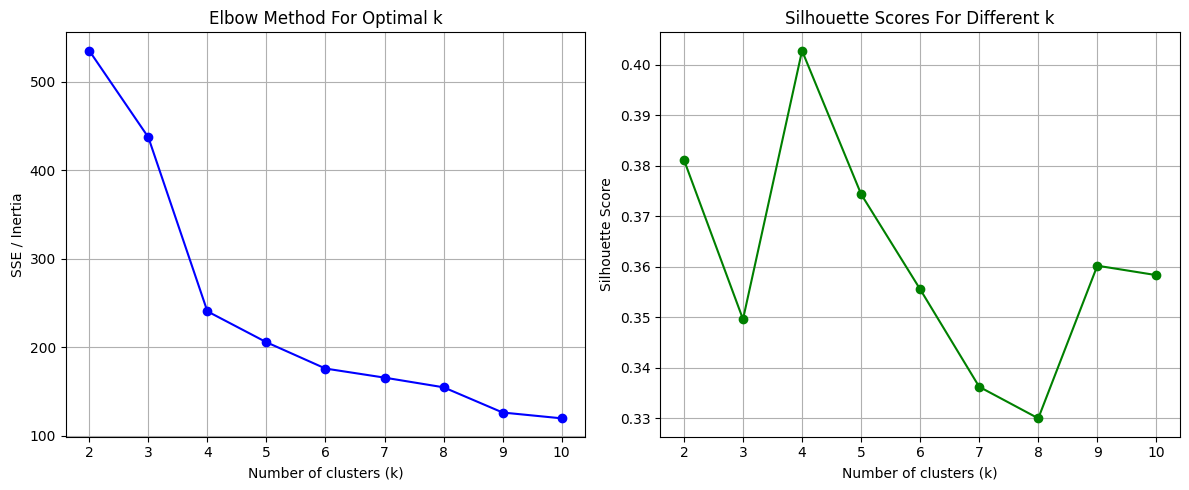

Suggested optimal number of clusters: 4


In [80]:
optimal_k = find_optimal_clusters(mca_coords)

In [81]:
kmeans = KMeans(n_clusters=4, random_state=42)  # adjust n_clusters as needed
clusters = kmeans.fit_predict(mca_coords)
mca_coords['cluster'] = clusters

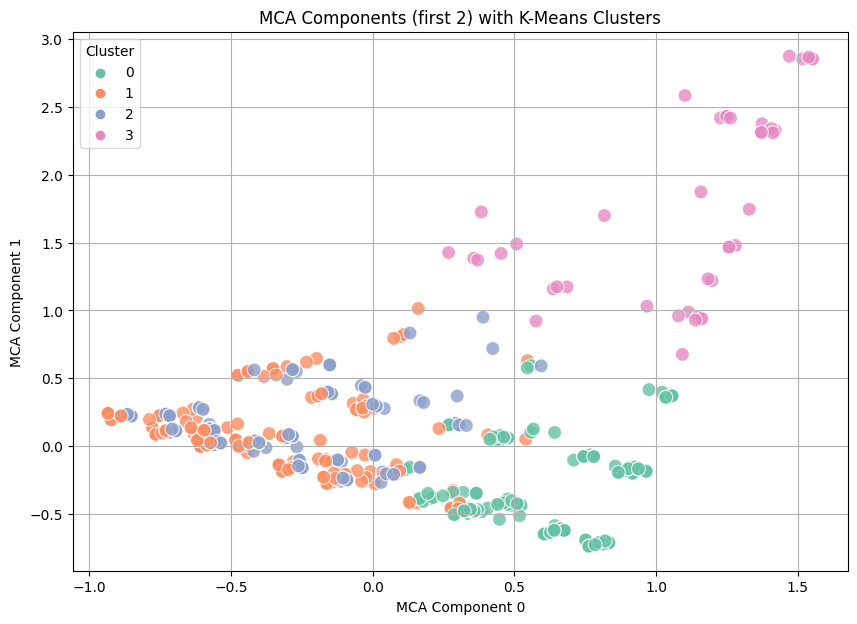

In [82]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=mca_coords[0], y=mca_coords[1],
    hue=mca_coords['cluster'],
    palette='Set2',
    s=100,
    alpha=0.8
)
plt.title('MCA Components (first 2) with K-Means Clusters')
plt.xlabel('MCA Component 0')
plt.ylabel('MCA Component 1')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

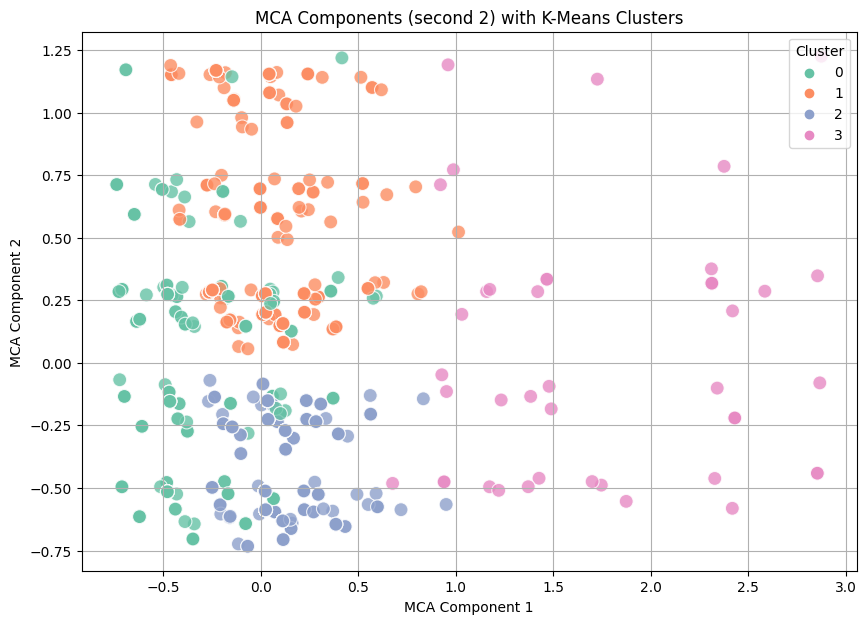

In [83]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=mca_coords[1], y=mca_coords[2],
    hue=mca_coords['cluster'],
    palette='Set2',
    s=100,
    alpha=0.8
)
plt.title('MCA Components (second 2) with K-Means Clusters')
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

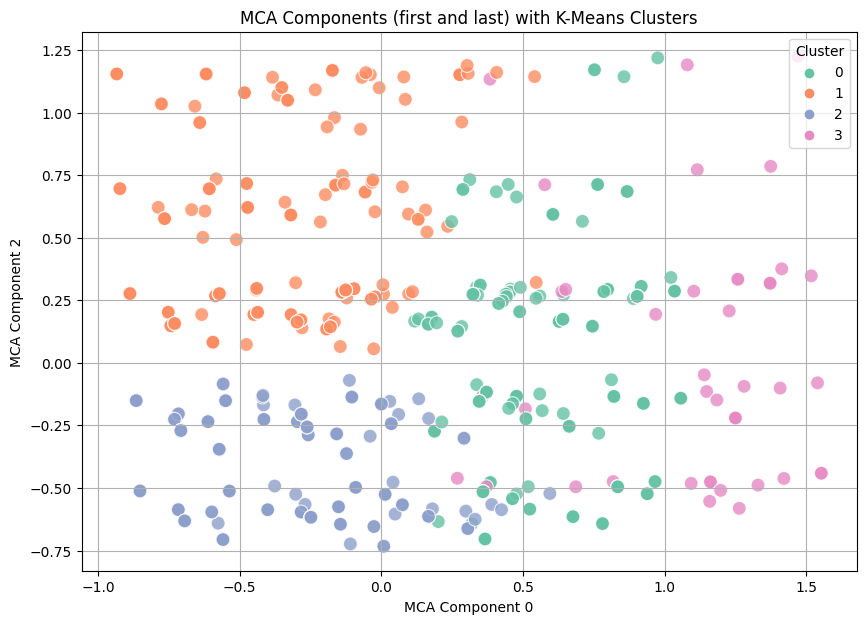

In [84]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=mca_coords[0], y=mca_coords[2],
    hue=mca_coords['cluster'],
    palette='Set2',
    s=100,
    alpha=0.8
)
plt.title('MCA Components (first and last) with K-Means Clusters')
plt.xlabel('MCA Component 0')
plt.ylabel('MCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

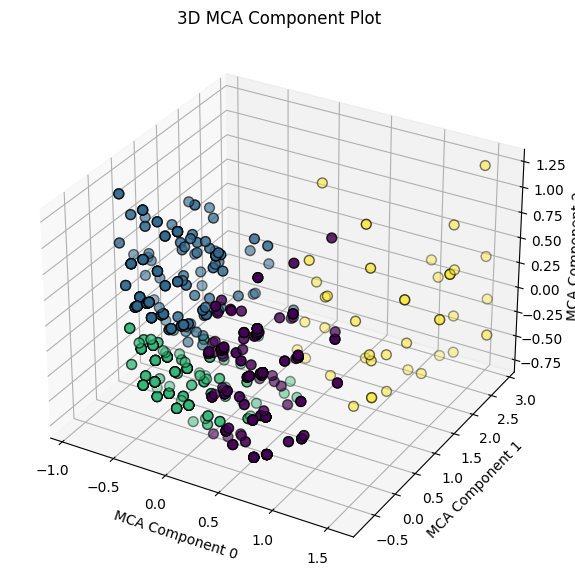

In [85]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the three MCA components
ax.scatter(
    mca_coords[0],  # Component 0
    mca_coords[1],  # Component 1
    mca_coords[2],  # Component 2
    c=mca_coords['cluster'],     # You can later color by cluster labels
    s=50,
    edgecolor='k'
)

ax.set_xlabel('MCA Component 0')
ax.set_ylabel('MCA Component 1')
ax.set_zlabel('MCA Component 2')
ax.set_title('3D MCA Component Plot')

plt.show()


In [86]:
# mhc_types = df.iloc[:,48].apply(lambda x:x.split("|")).to_list()

In [87]:
# mhc_types

In [88]:
# mhc_types = list(chain.from_iterable(mhc_types))

In [89]:
# mhc_types

In [90]:
# mhc_db = dict(Counter(mhc_types))

In [91]:
# other = 0
# new_mhc_db = {}
# for key,value in mhc_db.items():
#     if value <= 15:
#         other += value
#     else:
#         new_mhc_db[key] = value    

In [92]:
# print(other)

In [93]:
# new_mhc_db["Other"] = other

In [94]:
# new_mhc_db

In [95]:
# plt.pie(new_mhc_db.values(), labels=new_mhc_db.keys(), autopct='%1.1f%%')
# plt.title('MHC Types')
# plt.show()

In [96]:
# gender_df = df.query("'Mood Disorder (Depression, Bipolar Disorder, etc)' in `If yes, what condition(s) have you been diagnosed with?`")

In [97]:
# gender_df["What is your gender?"].value_counts()

In [98]:
# plt.pie(gender_df["What is your gender?"].value_counts().values, labels=gender_df["What is your gender?"].value_counts().index, autopct='%1.1f%%')
# plt.title('Gender Segmentation of Mood Disorders')
# plt.show()

In [99]:
# df.iloc[:,9].unique()

In [100]:
# pd.get_dummies(df.iloc[:,9],prefix="Question 9")